In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.95838% 	8.0498% 	0.04888		0.03759		0.0		1.0	
(1024,256) 	95.4% 		0.47886% 	6.35467% 	0.82382		0.82926		0.0		0.98755	
(1024,1024) 	3.04% 		1.89935% 	2.20633% 	0.02452		0.00228		0.0		0.55569	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.06624 1.00000 0.93376 	(213910, 0.9037879560274013) 0.90835 0.90379 0.00456 	(688427, 0.938751472320377) 0.00510 0.93875 0.93365 	
(32635, 1.0) 0.00031 1.00000 0.99969 	(212974, 0.8941978001127759) 0.89940 0.89420 0.00521 	(4240, 0.9623085983510011) 0.19784 0.96231 0.76447 	
(2436, 1.0) 0.60529 1.00000 0.39471 	(44828, 0.8401417658060423) 0.86016 0.84014 0.02002 	(694929, 0.9799764428739693) 0.00118 0.97998 0.97879 	
(55808, 1.0) 0.00000 1.00000 1.00000 	(232148, 0.8783613613364569) 0.88253 0.87836 0.00417 	(600540, 0.5747938751472321) 0.01094 0.57479 0.56385 	
(44159, 1.0) 0.01740 1.00000 0.98260 	(106790, 0.8420843224691953) 0.84769 0.84208 0.00560 	(226406, 0.8680800942285042) 0.06348 0.86808 0.80460 	
(25344, 1.0) 0.61325 1.00000 0.38675 	(155900, 0.8219974944514251) 0.83108 0.82200 0.00908 	(122896, 0.99528857

(24228, 1.0) 0.00000 1.00000 1.00000 	(56719, 0.8987392914948396) 0.85234 0.89874 0.04640 	(387327, 0.872791519434629) 0.02815 0.87279 0.84464 	
(6926, 1.0) 0.09097 1.00000 0.90903 	(41727, 0.8431126758477174) 0.82969 0.84311 0.01342 	(311445, 0.9670200235571261) 0.02445 0.96702 0.94257 	
(75907, 1.0) 0.35552 1.00000 0.64448 	(128738, 0.8907939275311966) 0.84530 0.89079 0.04549 	(478600, 0.9528857479387515) 0.01478 0.95289 0.93811 	
(49659, 1.0) 0.13856 1.00000 0.86144 	(45049, 0.8941921952489368) 0.85608 0.89419 0.03811 	(1053, 0.7997644287396938) 0.17146 0.79976 0.62830 	
(1921, 1.0) 0.27711 1.00000 0.72289 	(19331, 0.7751304321123971) 0.75933 0.77513 0.01580 	(69727, 0.9187279151943463) 0.09290 0.91873 0.82583 	
(83203, 1.0) 0.50237 1.00000 0.49763 	(137038, 0.9067975246968422) 0.86113 0.90680 0.04567 	(134243, 0.9599528857479388) 0.12986 0.95995 0.83009 	
(1412, 1.0) 0.41591 1.00000 0.58409 	(230832, 0.8657114302948561) 0.88253 0.86571 0.01682 	(168119, 0.4369846878680802) 0.04001 

(88706, 1.0) 0.38547 1.00000 0.61453 	(241612, 0.8768043755984459) 0.88251 0.87680 0.00571 	(79093, 0.8881036513545347) 0.02738 0.88810 0.86072 	
(7579, 1.0) 0.01890 1.00000 0.98110 	(25242, 0.7675573019314136) 0.75680 0.76756 0.01076 	(484601, 0.568904593639576) 0.00858 0.56890 0.56033 	
(46591, 1.0) 0.04175 1.00000 0.95825 	(75072, 0.8197714824987464) 0.85642 0.81977 0.03665 	(593006, 0.9988221436984688) 0.02260 0.99882 0.97622 	
(69510, 1.0) 0.00039 1.00000 0.99961 	(201969, 0.8519213326274235) 0.87156 0.85192 0.01964 	(214035, 0.795053003533569) 0.08132 0.79505 0.71373 	
(104576, 1.0) 0.76756 1.00000 0.23244 	(144387, 0.8451563176955528) 0.85982 0.84516 0.01466 	(18502, 0.9116607773851589) 0.23359 0.91166 0.67807 	
(97664, 1.0) 0.12069 1.00000 0.87931 	(252561, 0.9032751260514961) 0.90299 0.90328 0.00028 	(196927, 1.0) 0.02331 1.00000 0.97669 	
(1922, 1.0) 0.55905 1.00000 0.44095 	(256716, 0.8929296810236506) 0.88232 0.89293 0.01061 	(11464, 0.7891637220259129) 0.11113 0.78916 0.67

(3726, 1.0) 0.43614 1.00000 0.56386 	(54492, 0.8709233285418301) 0.86863 0.87092 0.00229 	(36930, 0.17432273262661965) 0.17018 0.17432 0.00414 	
(14720, 1.0) 0.26465 1.00000 0.73535 	(236889, 0.896398602496468) 0.88277 0.89640 0.01363 	(244026, 0.8904593639575972) 0.03331 0.89046 0.85715 	
(5780, 1.0) 0.03835 1.00000 0.96165 	(144519, 0.8496024406161163) 0.86252 0.84960 0.01292 	(117977, 0.8150765606595995) 0.04678 0.81508 0.76830 	
(105985, 1.0) 0.54206 1.00000 0.45794 	(121159, 0.8188181979856338) 0.88323 0.81882 0.06441 	(582333, 0.9293286219081272) 0.00481 0.92933 0.92452 	
(86016, 1.0) 0.66782 1.00000 0.33218 	(192332, 0.8975279933311768) 0.88792 0.89753 0.00961 	(293965, 0.9305064782096585) 0.07931 0.93051 0.85120 	
(39068, 1.0) 0.00000 1.00000 1.00000 	(65451, 0.8024310944854609) 0.80725 0.80243 0.00482 	(90164, 0.8939929328621907) 0.13391 0.89399 0.76009 	
(4369, 1.0) 0.08785 1.00000 0.91215 	(230983, 0.8535026070003096) 0.88253 0.85350 0.02902 	(25121, 0.9210836277974088) 0.00

(40963, 1.0) 0.01198 1.00000 0.98802 	(243037, 0.882758693581502) 0.88253 0.88276 0.00023 	(137370, 0.9034157832744406) 0.07430 0.90342 0.82912 	
(19835, 1.0) 0.00932 1.00000 0.99068 	(62023, 0.8601789274400264) 0.84018 0.86018 0.02000 	(18460, 0.9811542991755006) 0.23734 0.98115 0.74382 	
(129280, 1.0) 0.00544 1.00000 0.99456 	(50937, 0.8313938941669136) 0.85622 0.83139 0.02483 	(446901, 0.96113074204947) 0.02539 0.96113 0.93574 	
(48128, 1.0) 0.01883 1.00000 0.98117 	(185502, 0.841465297201884) 0.87386 0.84147 0.03240 	(3603, 0.7361601884570083) 0.01658 0.73616 0.71958 	
(48522, 1.0) 0.06745 1.00000 0.93255 	(217997, 0.8950593016451204) 0.91523 0.89506 0.02017 	(468655, 0.9964664310954064) 0.00233 0.99647 0.99414 	
(10778, 1.0) 0.45922 1.00000 0.54078 	(159952, 0.8584501953844718) 0.87452 0.85845 0.01607 	(340051, 0.8904593639575972) 0.03023 0.89046 0.86023 	
(100099, 1.0) 0.00301 1.00000 0.99699 	(217199, 0.9184578743346412) 0.91582 0.91846 0.00264 	(841415, 0.4782096584216726) 0.00

(58373, 1.0) 0.50135 1.00000 0.49865 	(259163, 0.8174080355227247) 0.80888 0.81741 0.00853 	(104695, 0.977620730270907) 0.06913 0.97762 0.90849 	
(8193, 1.0) 0.03043 1.00000 0.96957 	(175764, 0.8656188197498577) 0.87029 0.86562 0.00467 	(640284, 0.9363957597173145) 0.01105 0.93640 0.92535 	
(91397, 1.0) 0.00779 1.00000 0.99221 	(140329, 0.9288307329111433) 0.87074 0.92883 0.05809 	(734568, 0.8904593639575972) 0.00180 0.89046 0.88866 	
(47491, 1.0) 0.02430 1.00000 0.97570 	(255507, 0.8895527033759333) 0.87740 0.88955 0.01216 	(450326, 0.9375736160188458) 0.00051 0.93757 0.93707 	
(23817, 1.0) 0.01048 1.00000 0.98952 	(248701, 0.9042644236060254) 0.89446 0.90426 0.00981 	(243864, 0.34275618374558303) 0.05466 0.34276 0.28810 	
(23434, 1.0) 0.00001 1.00000 0.99999 	(117161, 0.8381221871325827) 0.85351 0.83812 0.01539 	(310390, 0.49469964664310956) 0.09247 0.49470 0.40223 	
(82820, 1.0) 0.44963 1.00000 0.55037 	(49206, 0.7949334068627762) 0.79356 0.79493 0.00137 	(246223, 0.9528857479387515

(26382, 1.0) 0.00469 1.00000 0.99531 	(259553, 0.807456119297689) 0.83400 0.80746 0.02654 	(23555, 0.9599528857479388) 0.25381 0.95995 0.70614 	
(9852, 1.0) 0.07236 1.00000 0.92764 	(244442, 0.8773632836088642) 0.88059 0.87736 0.00322 	(585926, 0.9163722025912839) 0.00724 0.91637 0.90913 	
(55680, 1.0) 0.08184 1.00000 0.91816 	(157713, 0.8782103694437675) 0.85651 0.87821 0.02171 	(91189, 0.938751472320377) 0.13802 0.93875 0.80073 	
(31101, 1.0) 0.00039 1.00000 0.99961 	(244670, 0.8743998106929595) 0.88246 0.87440 0.00806 	(266377, 0.3250883392226148) 0.08003 0.32509 0.24506 	
(86530, 1.0) 0.06852 1.00000 0.93148 	(14588, 0.7732518079759424) 0.66598 0.77325 0.10727 	(531014, 0.6678445229681979) 0.00178 0.66784 0.66606 	
(51964, 1.0) 0.32020 1.00000 0.67980 	(52676, 0.8789885737958777) 0.87627 0.87899 0.00272 	(461859, 1.0) 0.06844 1.00000 0.93156 	
(4390, 1.0) 0.05410 1.00000 0.94590 	(127125, 0.8358503411308392) 0.87232 0.83585 0.03647 	(392444, 0.7962308598351) 0.03651 0.79623 0.75972

(87682, 1.0) 0.31321 1.00000 0.68679 	(239258, 0.8814854131309768) 0.88253 0.88149 0.00104 	(760629, 0.4758539458186102) 0.00068 0.47585 0.47517 	
(3711, 1.0) 0.68198 1.00000 0.31802 	(149162, 0.9175307665789) 0.94123 0.91753 0.02370 	(765676, 0.10718492343934037) 0.00130 0.10718 0.10588 	
(263, 1.0) 0.31596 1.00000 0.68404 	(243521, 0.8831283167386529) 0.88253 0.88313 0.00060 	(145555, 0.5406360424028269) 0.09805 0.54064 0.44258 	
(86784, 1.0) 0.01122 1.00000 0.98878 	(72008, 0.8190416842019104) 0.88255 0.81904 0.06351 	(465981, 0.020023557126030708) 0.02036 0.02002 0.00034 	
(49571, 1.0) 0.00041 1.00000 0.99959 	(164062, 0.8304663727060659) 0.87600 0.83047 0.04553 	(329879, 0.9151943462897527) 0.04014 0.91519 0.87505 	
(74892, 1.0) 0.05938 1.00000 0.94062 	(80777, 0.9543265264577213) 0.89542 0.95433 0.05891 	(61537, 0.9399293286219083) 0.08625 0.93993 0.85368 	
(33024, 1.0) 0.00802 1.00000 0.99198 	(171462, 0.8950243203895636) 0.87601 0.89502 0.01901 	(106614, 0.9658421672555949) 0.1

(31229, 1.0) 0.10387 1.00000 0.89613 	(163886, 0.8382069241630572) 0.86775 0.83821 0.02954 	(118807, 0.7349823321554771) 0.18270 0.73498 0.55229 	
(29055, 1.0) 0.00398 1.00000 0.99602 	(120865, 0.8892079697663472) 0.88378 0.88921 0.00543 	(43666, 0.7349823321554771) 0.02400 0.73498 0.71098 	
(9230, 1.0) 0.00000 1.00000 1.00000 	(179538, 0.8328468285242104) 0.86766 0.83285 0.03481 	(327060, 0.4782096584216726) 0.02168 0.47821 0.45653 	
(1671, 1.0) 0.40024 1.00000 0.59976 	(175724, 0.8671745302365235) 0.88126 0.86717 0.01408 	(6157, 0.8869257950530036) 0.30167 0.88693 0.58526 	
(71168, 1.0) 0.03267 1.00000 0.96733 	(64325, 0.7848895001929161) 0.79845 0.78489 0.01356 	(3191, 0.6690223792697292) 0.19699 0.66902 0.47203 	
(102402, 1.0) 0.18315 1.00000 0.81685 	(57185, 0.8021564612159402) 0.84128 0.80216 0.03913 	(263184, 0.7891637220259129) 0.11709 0.78916 0.67207 	
(47617, 1.0) 0.00000 1.00000 1.00000 	(181929, 0.8470636133854084) 0.87116 0.84706 0.02409 	(65729, 0.6124852767962309) 0.0899

(64384, 1.0) 0.52759 1.00000 0.47241 	(129759, 0.8238710292745943) 0.84000 0.82387 0.01613 	(85020, 0.9729093050647822) 0.25371 0.97291 0.71920 	
(9229, 1.0) 0.00386 1.00000 0.99614 	(64122, 0.7937210765695902) 0.84016 0.79372 0.04643 	(202845, 0.12720848056537107) 0.09352 0.12721 0.03369 	
(20129, 1.0) 0.00000 1.00000 1.00000 	(150770, 0.9140522969866226) 0.87701 0.91405 0.03704 	(421573, 0.9411071849234394) 0.01346 0.94111 0.92765 	
(41743, 1.0) 0.03559 1.00000 0.96441 	(136936, 0.8717193563672403) 0.87168 0.87172 0.00004 	(196686, 0.7997644287396938) 0.07118 0.79976 0.72858 	
(39035, 1.0) 0.00014 1.00000 0.99986 	(45431, 0.8442142210558946) 0.79792 0.84421 0.04629 	(534739, 0.9505300353356891) 0.00988 0.95053 0.94065 	
(81412, 1.0) 0.62706 1.00000 0.37294 	(221411, 0.9088204445320582) 0.89174 0.90882 0.01708 	(225562, 0.9281507656065962) 0.06096 0.92815 0.86719 	
(42162, 1.0) 0.00000 1.00000 1.00000 	(90847, 0.8432994664435706) 0.88592 0.84330 0.04262 	(70712, 0.850412249705536) 0.2

(38726, 1.0) 0.00000 1.00000 1.00000 	(104664, 0.8318317912717332) 0.84481 0.83183 0.01297 	(11547, 0.9199057714958776) 0.15992 0.91991 0.75998 	
(46877, 1.0) 0.00000 1.00000 1.00000 	(65178, 0.7874688920173168) 0.80187 0.78747 0.01440 	(246302, 0.8869257950530036) 0.00924 0.88693 0.87768 	
(33022, 1.0) 0.00280 1.00000 0.99720 	(225786, 0.8826802938576508) 0.88957 0.88268 0.00689 	(415373, 0.9988221436984688) 0.00984 0.99882 0.98898 	
(15235, 1.0) 0.49797 1.00000 0.50203 	(191652, 0.868715650240178) 0.88189 0.86872 0.01317 	(103819, 0.9469964664310954) 0.04856 0.94700 0.89843 	
(15506, 1.0) 0.03602 1.00000 0.96398 	(151641, 0.8253741727779265) 0.80231 0.82537 0.02306 	(536622, 0.9599528857479388) 0.03006 0.95995 0.92989 	
(13181, 1.0) 0.00444 1.00000 0.99556 	(218687, 0.9106961520087443) 0.90158 0.91070 0.00912 	(396334, 0.9528857479387515) 0.07154 0.95289 0.88134 	
(6655, 1.0) 0.41829 1.00000 0.58171 	(14691, 0.8487331979469075) 0.69839 0.84873 0.15035 	(213272, 0.92226148409894) 0.01

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


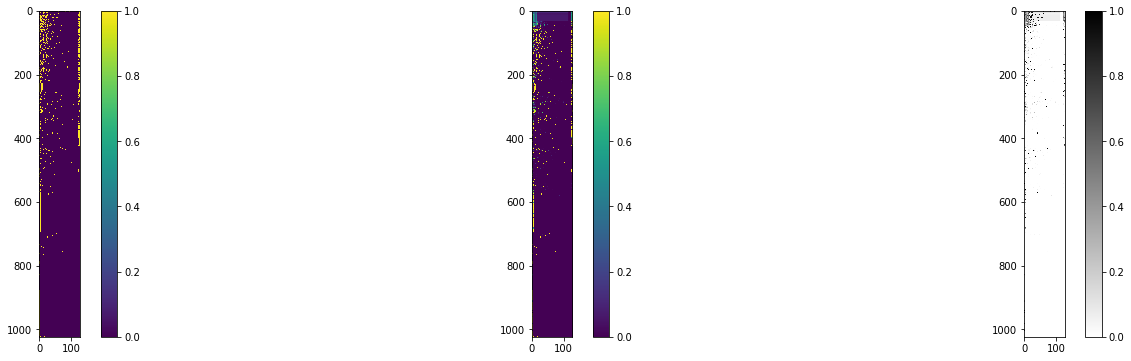

4.841989e-06
0.9875503


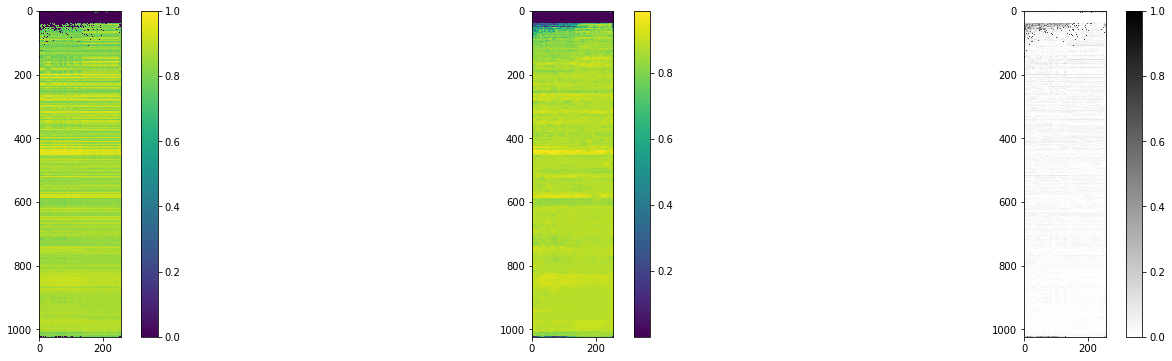

2.956523e-17
0.5556934


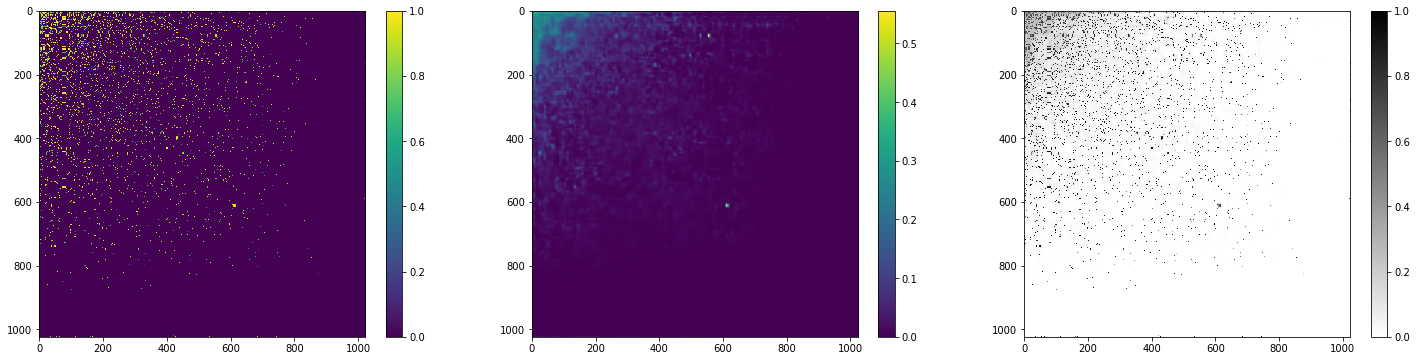

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_10/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


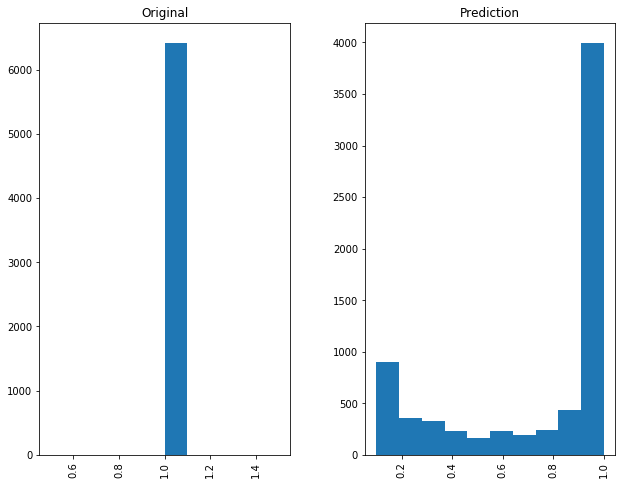

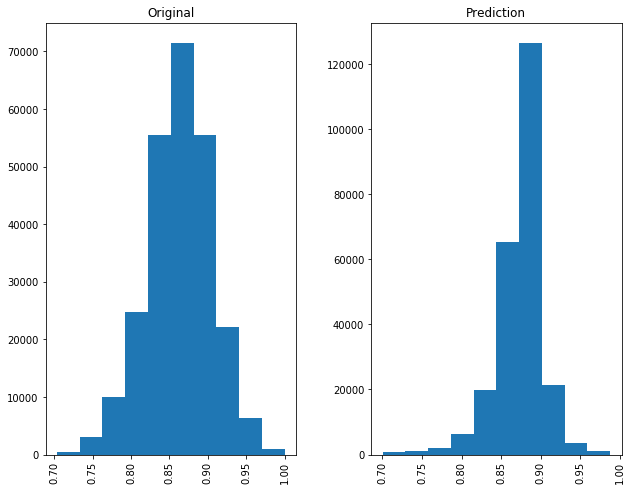

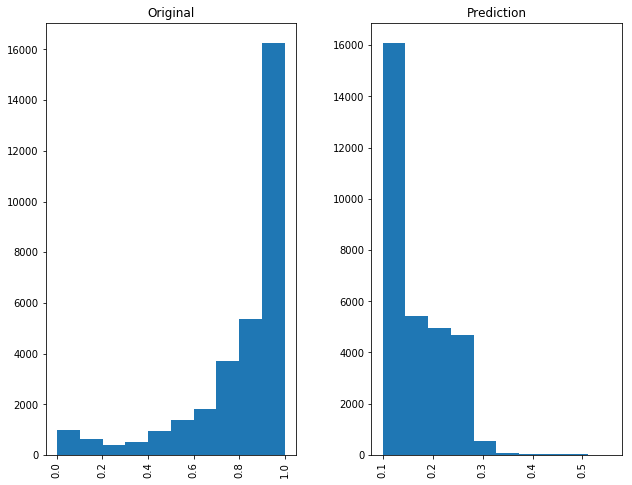

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


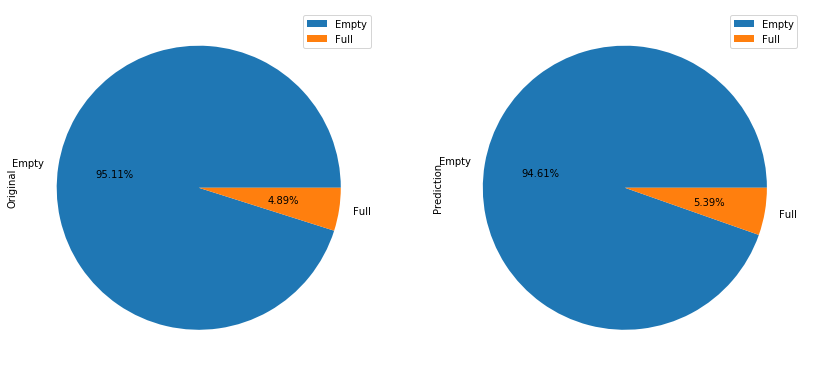

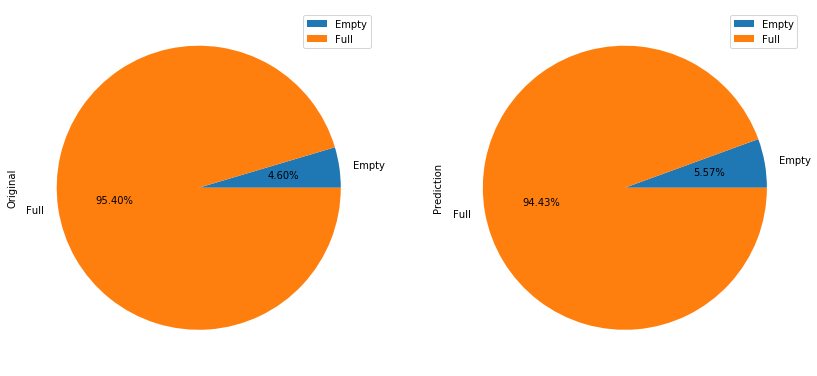

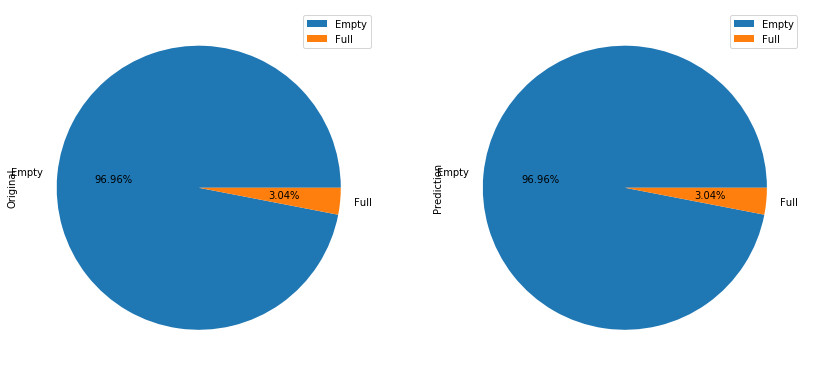

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

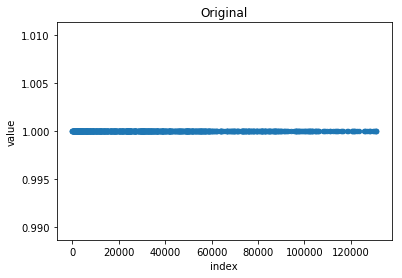

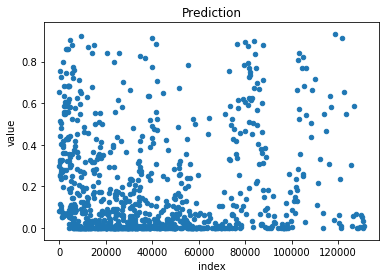

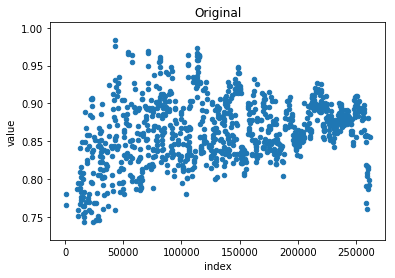

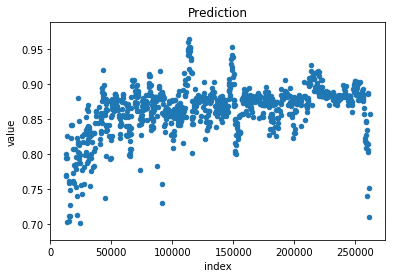

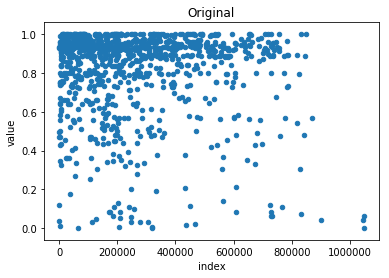

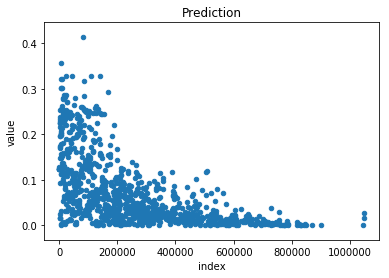

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['index', 'value'])
    df.plot.scatter(x='index', y='value', title='Original');

    df = pd.DataFrame(new_predict_data, columns=['index', 'value'])
    df.plot.scatter(x='index', y='value', title='Prediction');

    new_predict_data

1000
1000
1000


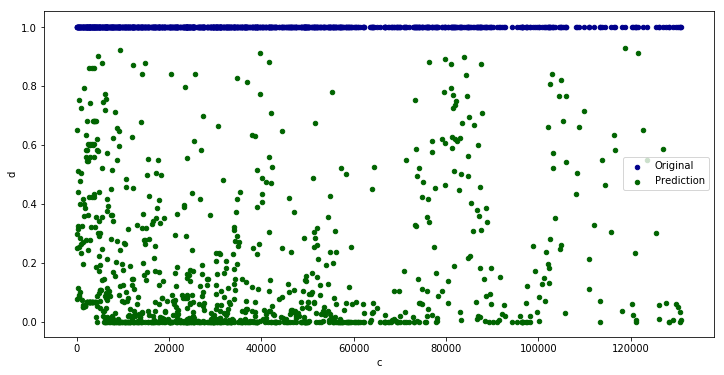

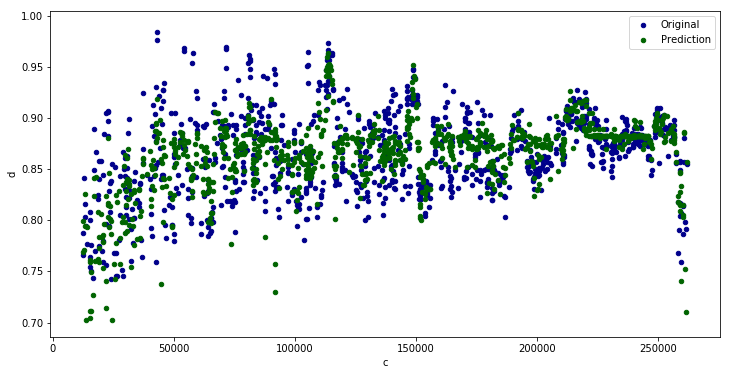

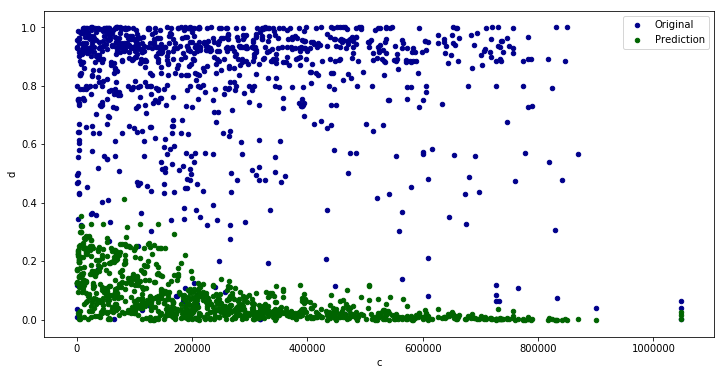

In [16]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.0:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

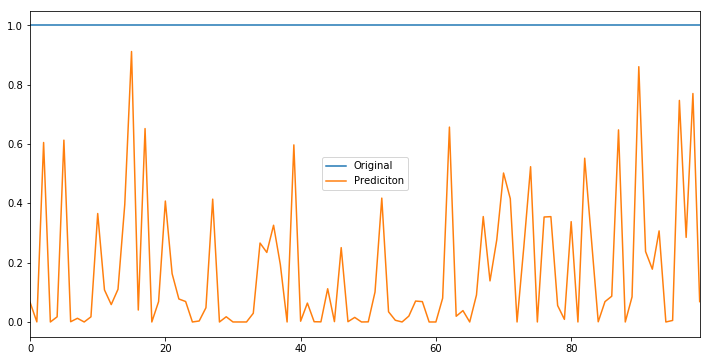

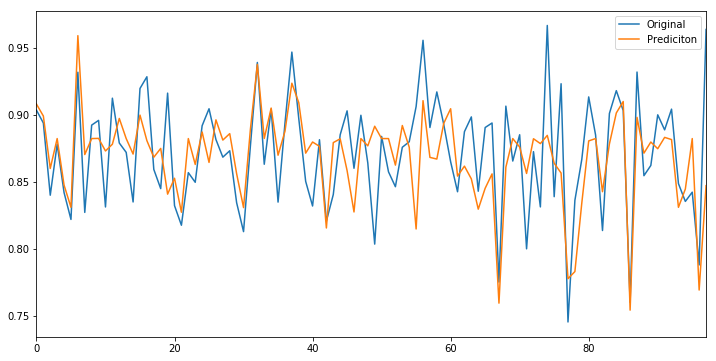

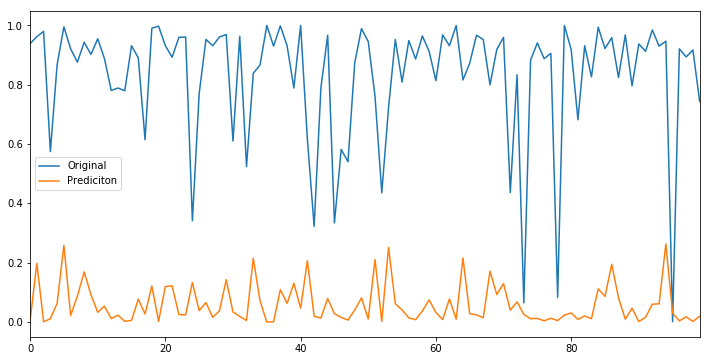

In [19]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.0:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))